<a href="https://colab.research.google.com/github/Suvarnaph/hello-world/blob/master/Capstone_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import color
import skimage.transform as skt
import os
import h5py
plt.style.use('default')


In [0]:
#with h5py.File('drive/My Drive/AIML/Capstone_Team/data_train_1.h5', 'r') as hf:
Images = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/Images_Shoulder.npy')
labels = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/labels_Shoulder.npy')

In [0]:
import cv2
rez=(120,120)
def preprocess(data):
  from skimage import exposure
  data_proc = np.zeros((data.shape[0],data.shape[1],rez[0],rez[1]))
  #data_proc=[]
  for i in range(0, data.shape[0]):
    img = cv2.resize(data[i,0], rez)# , preserve_range=True)
    img=exposure.equalize_hist(img)
    #img=data[i,0]
    img=(img - img.mean())/(1.0*img.std())
    img=(img-img.min())/(1.0*(1e-2+img.max()-img.min()))	
    data_proc[i,0,:,:]=img
  return np.array(data_proc)

In [5]:
ImageArr = np.array(Images).reshape(len(Images),1)
ImageArr.shape

(8379, 1)

In [0]:
from sklearn.model_selection import train_test_split
data_proc = preprocess(ImageArr)

In [0]:
data_proc_rgb = []

for s in range(0,data_proc.shape[0]):
    rgb=np.zeros((data_proc.shape[2],data_proc.shape[3],3))
    rgb[:,:,0]=data_proc[s,0,:,:]
    rgb[:,:,1]=data_proc[s,0,:,:]
    rgb[:,:,2]=data_proc[s,0,:,:]
    data_proc_rgb.append(rgb)
    
data_proc_rgb=np.array(data_proc_rgb)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(data_proc_rgb,
                                                             labels, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [9]:
x_train[10].max()

0.9971122495878816

In [10]:
x_train.shape

(6703, 120, 120, 3)

In [11]:
import tensorflow as tf
from keras import applications

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (120, 120, 3))


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [0]:
for layer in model.layers:
   layer.trainable = False

In [0]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
#x = Dropout(0.5)(x)
#x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

In [15]:
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping


batch_size = 25
epochs = 50
nb_train_samples = 4125
nb_validation_samples = 466 

model_final = Model(input = model.input, output = predictions)
model_final.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
horizontal_flip = True,
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
horizontal_flip = True,
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow(x_train,y_train,
batch_size = batch_size)

validation_generator = test_datagen.flow(x_test,y_test)

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = x_train.shape[0],
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = 100)
#callbacks = [checkpoint, early])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=<keras_pre..., steps_per_epoch=268, validation_steps=100)`


Epoch 1/50
268/268 [==============================] - 53s 199ms/step - loss: 0.7140 - acc: 0.5203 - val_loss: 0.6805 - val_acc: 0.5840
Epoch 2/50
268/268 [==============================] - 48s 180ms/step - loss: 0.6865 - acc: 0.5598 - val_loss: 0.6800 - val_acc: 0.5744
Epoch 3/50
268/268 [==============================] - 48s 179ms/step - loss: 0.6825 - acc: 0.5619 - val_loss: 0.6828 - val_acc: 0.5661
Epoch 4/50
268/268 [==============================] - 48s 179ms/step - loss: 0.6768 - acc: 0.5701 - val_loss: 0.6719 - val_acc: 0.5791
Epoch 5/50
268/268 [==============================] - 48s 178ms/step - loss: 0.6755 - acc: 0.5779 - val_loss: 0.6686 - val_acc: 0.5918
Epoch 6/50
268/268 [==============================] - 48s 179ms/step - loss: 0.6758 - acc: 0.5816 - val_loss: 0.6627 - val_acc: 0.6104
Epoch 7/50
268/268 [==============================] - 48s 179ms/step - loss: 0.6742 - acc: 0.5744 - val_loss: 0.6631 - val_acc: 0.5994
Epoch 8/50
268/268 [==============================] - 4

In [16]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 120, 120

### Build the network 
img_input = Input(shape=(120, 120, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

model = Model(input = img_input, output = x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`


In [0]:
import h5py
weights_path =  'drive/My Drive/AIML/Capstone_Team/vgg16_1.h5' # ('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5)
f = h5py.File(weights_path)

In [36]:
import numpy as np
Images_valid = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/Images_Shoulder_Valid.npy')
labels_valid = np.load('drive/My Drive/AIML/Capstone_Team/Mura_Dataset_Loaded/labels_Shoulder_Valid.npy')
len(Images_valid)

563

In [0]:
ImageArr = np.array(Images_valid).reshape(len(Images_valid),1)
data_proc = preprocess(ImageArr)


data_proc_rgb = []

for s in range(0,data_proc.shape[0]):
    rgb=np.zeros((data_proc.shape[2],data_proc.shape[3],3))
    rgb[:,:,0]=data_proc[s,0,:,:]
    rgb[:,:,1]=data_proc[s,0,:,:]
    rgb[:,:,2]=data_proc[s,0,:,:]
    data_proc_rgb.append(rgb)
    
data_proc_rgb=np.array(data_proc_rgb)
labels_pred = model_final.predict(data_proc_rgb)

In [39]:
labels_pred.shape

(563, 1)

0.7157389877571627


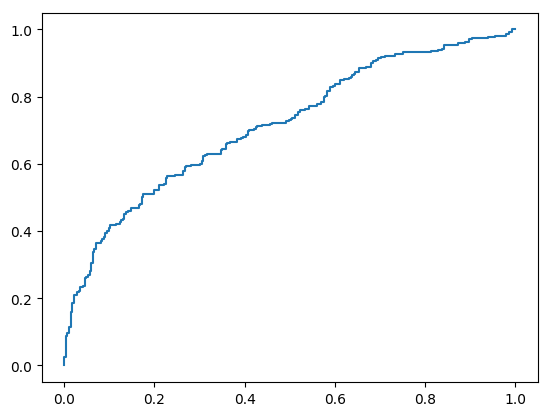

In [40]:
import sklearn
fpr,tpr, thresh=sklearn.metrics.roc_curve(labels_valid[:], labels_pred[:])

plt.plot(fpr,tpr)
print(sklearn.metrics.roc_auc_score(labels_valid[:],labels_pred[:]))